# Case Studies Part 1

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [16]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

In [17]:
# import functions from modsim

from modsim import *

This chapter presents case studies where you can apply the tools we have learned so far to problems involving population growth, queueing systems, and tree growth. 

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
Click here to access the notebooks: <https://allendowney.github.io/ModSimPy/>.

## Historical World Population

The Wikipedia page about world population growth includes estimates for world population from 12,000 years ago to the present (see <https://en.wikipedia.org/wiki/World_population_estimates.html>).

The following cells download an archived version of this page and read the data into a Pandas `DataFrame`.

In [18]:
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/data/World_population_estimates.html')

In [19]:
from pandas import read_html

filename = 'World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
len(tables)

6

In [20]:
table1 = tables[1]
table1.head()

,Population Reference Bureau (1973–2016)[15],United Nations Department of Economic and Social Affairs (2015)[16],Maddison (2008)[17],HYDE (2010)[citation needed],Tanton (1994)[18],Biraben (1980)[19],McEvedy & Jones (1978)[20],Thomlinson (1975)[21],Durand (1974)[22],Clark (1967)[23]
Year,,,,,,,,,,
-10000,NaN,NaN,NaN,2M[24],NaN,NaN,4.0,1–10M,NaN,NaN
-9000,NaN,NaN,NaN,4.,NaN,NaN,NaN,NaN,NaN,NaN
-8000,5.,NaN,NaN,5.,NaN,NaN,NaN,NaN,5–10M,NaN
-7000,NaN,NaN,NaN,8.,NaN,NaN,NaN,NaN,NaN,NaN
-6000,NaN,NaN,NaN,11.,NaN,NaN,NaN,NaN,NaN,NaN


Some of the values are null because not all researchers provide estimates for the same dates.

Again, we'll replace the long column names with more convenient abbreviations.

In [21]:
table1.columns = ['PRB', 'UN', 'Maddison', 'HYDE', 'Tanton', 
                  'Biraben', 'McEvedy & Jones', 'Thomlinson', 'Durand', 'Clark']

Some of the estimates are in a form Pandas doesn't recognize as numbers, but we can coerce them to be numeric.

In [22]:
for col in table1.columns:
    table1[col] = pd.to_numeric(table1[col], errors='coerce')

Here are the results.  Notice that we are working in millions now, not billions.

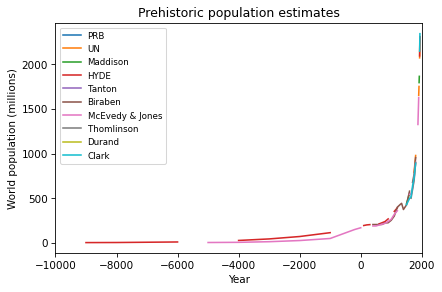

In [23]:
table1.plot()
decorate(xlim=[-10000, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistoric population estimates')
plt.legend(fontsize='small');

We can use `xlim` to zoom in on everything after Year 0.

The following figure shows the estimates of several research groups from 1 CE to the near present.

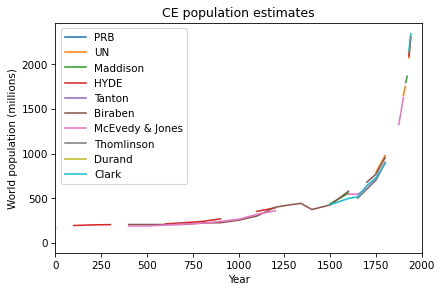

In [24]:
table1.plot()
decorate(xlim=[0, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='CE population estimates')

See if you can find a model that fits these estimates.
How well does your best model predict actual population growth from 1940 to the present?

In [25]:
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [26]:
un = table2.un / 1e9
census = table2.census / 1e9

### To get the best parameters for my quadratic model I did an optimization of least squares. The model is C0 + alpha*X + beta*X^2.  I would like at model with C0 = 200 and by 1940 is around 2300.  By using least_squares function from scipy.optimize I will have the parameter alpha and beta which makes that model the smallest difference to 2300

In [58]:
from scipy.optimize import least_squares
import numpy as np

X0 = 200
num_points = 1940

def residual(params):
    alpha, beta = params
    X_pred = np.zeros(num_points)
    X_pred[0] = X0


    for i in range(1, num_points):
        X_pred[i] = X_pred[i-1] + alpha * X_pred[i-1] + beta * X_pred[i-1] ** 2    
    
    return X_pred[1939] - 2300

initial_guess = [0, 0]  # Initial guess for alpha and beta
result = least_squares(residual, initial_guess)
alpha = result.x[0]
beta = result.x[1]

print("Estimated alpha:", alpha)
print("Estimated beta:", beta)


Estimated alpha: 1.0002464666786511e-08
Estimated beta: 2.357357613710233e-06


C:\Users\jrfal\AppData\Local\Temp\ipykernel_29472\1734635770.py:14: RuntimeWarning: overflow encountered in scalar power
  X_pred[i] = X_pred[i-1] + alpha * X_pred[i-1] + beta * X_pred[i-1] ** 2


### Now that I have my alpha and beta parameters I can use them in my quadratic growth model

In [59]:
def growth_func_quad2(t, pop, system):
    return system.alpha * pop + system.beta * pop**2

def run_simulation(system, growth_func):
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in range(system.t_0, system.t_end):
        growth = growth_func(t, results[t], system)
        results[t+1] = results[t] + growth
        
    return results


t_0 = census.index[1970-1950]
p_0 = census[t_0]

system = System(t_0 = 0,
                p_0 = 200,
                beta = 0.0000023573,
                t_end = 1940,
                alpha= 0.000000100024)


results = run_simulation(system, growth_func_quad2)

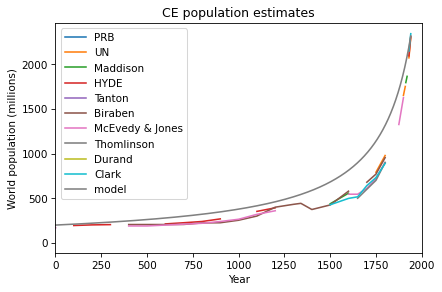

In [60]:
table1.plot()
results.plot(color='gray', label='model')
decorate(xlim=[0, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='CE population estimates')

### Although is not a perfect fit to the other data, I was pretty satisfied with the general shape of the curve

In [61]:
def plot_projections(table):
     """Plot world population projections.
    
    table: DataFrame with columns 'un' and 'census'
    """
    census_proj = table.census.dropna() / 1e9
    un_proj = table.un.dropna() / 1e9
    
    census_proj.plot(style=':', label='US Census')
    un_proj.plot(style='--', label='UN DESA')
    
    decorate(xlabel='Year', 
             ylabel='World population (billions)')



In [62]:
system = System(t_0 = 1950,
                p_0 = 2.5,
                beta = -1.8/1000,
                t_end = 2020,
                alpha= 25/1000)


results = run_simulation(system, growth_func_quad2)

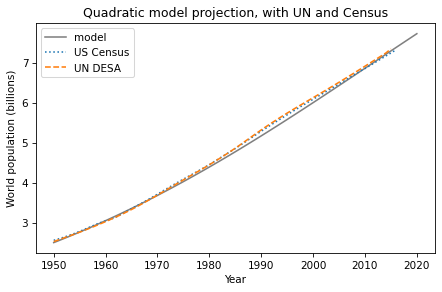

In [63]:
results.plot(color='gray', label='model')
plot_projections(table2)
decorate(title='Quadratic model projection, with UN and Census')

## One Queue Or Two?

This case study is related to *queueing theory*, which is the study of systems that involve waiting in lines, also known as "queues".

Suppose you are designing the checkout area for a new store. There is
enough room in the store for two checkout counters and a waiting area
for customers. You can make two lines, one for each counter, or one line that feeds both counters.

In theory, you might expect a single line to be better, but it has some practical drawbacks: in order to maintain a single line, you might have to install barriers, and customers might be put off by what seems to be a longer line, even if it moves faster.

So you'd like to check whether the single line is really better and by
how much. Simulation can help answer this question.

This figure shows the three scenarios we'll consider:

![One queue, one server (left), one queue, two servers (middle), two
queues, two servers (right).](https://github.com/AllenDowney/ModSim/raw/main/figs/queue.png)
*One queue, one server (left), one queue, two servers (middle), two
queues, two servers (right).*

As we did in the bike share model, we'll divide time into discrete time steps of one minute.
And we'll assume that a customer is equally likely to arrive during any time step. 
I'll denote this probability using the Greek letter lambda, $\lambda$, or the variable name `lam`. The value of $\lambda$ probably varies from day to day, so we'll have to consider a range of possibilities.

Based on data from other stores, you know that it takes 5 minutes for a customer to check out, on average. But checkout times are variable: most customers take less than 5 minutes, but some take substantially more. A simple way to model this variability is to assume that when a customer is checking out, they always have the same probability of finishing during the next time step, regardless of how long they have been checking out. I'll denote this probability using the Greek letter mu, $\mu$, or the variable name `mu`.

If we choose $\mu=1/5$ per minute, the average time for each checkout
will be 5 minutes, which is consistent with the data. Most people take less than 5 minutes, but a few take substantially longer, which is probably not a bad model of the distribution in real stores.

Now we're ready to implement the model. In the repository for this book, you'll find a notebook called *queue.ipynb* that contains some code to get you started and instructions.
You can download it from <https://github.com/AllenDowney/ModSimPy/raw/master/examples/queue.ipynb> or run it on Colab at <https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master/examples/queue.ipynb>.

As always, you should practice incremental development: write no more
than one or two lines of code at a time, and test as you go!

## Predicting Salmon Populations

Each year the U.S. Atlantic Salmon Assessment Committee reports
estimates of salmon populations in oceans and rivers in the northeastern United States. The reports are useful for monitoring changes in these populations, but they generally do not include predictions.

The goal of this case study is to model year-to-year changes in
population, evaluate how predictable these changes are, and estimate the probability that a particular population will increase or decrease in the next 10 years.

As an example, I use data from the 2017 report, which provides population estimates for the Narraguagus and Sheepscot Rivers
in Maine.

In the repository for this book, you'll find a notebook called
*salmon.ipynb* that contains this data and some code to get you started.
You can download it from <https://github.com/AllenDowney/ModSimPy/raw/master/examples/salmon.ipynb> or run it on Colab at <https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master/examples/salmon.ipynb>.

You should take my instructions as suggestions; if you want to try
something different, please do!



## Tree Growth

This case study is based on "Height-Age Curves for Planted Stands of
Douglas Fir, with Adjustments for Density", a working paper by
Flewelling et al.
It provides *site index curves*, which are curves that show the
expected height of the tallest tree in a stand of Douglas fir as a
function of age, for a stand where the trees are the same age.
Depending on the quality of the site, the trees might grow more quickly or slowly. So each curve is identified by a *site index* that indicates the quality of the site.

The goal of this case study is to explain the shape of these
curves, that is, why trees grow the way they do.
The answer I propose involves fractal dimensions, so you might find it interesting.

In the repository for this book, you'll find a notebook called
*trees.ipynb* that incrementally develops a model of tree growth and uses it to fit the data.
You can download it from <https://github.com/AllenDowney/ModSimPy/raw/master/examples/trees.ipynb> or run it on Colab at <https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master/examples/trees.ipynb>.

There are no exercises in this case study, but it is an example of what you can do with the tools we have so far and a preview of what you will be able to do with the tools in the next few chapters.